<a href="https://colab.research.google.com/github/AlexKryshtop/Cirrhosis-Prediction/blob/main/cirrhosis_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from collections import defaultdict

from sklearn.metrics import roc_auc_score, roc_auc_score
from itertools import product

from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cirrhosis-prediction-dataset/cirrhosis.csv


In [ ]:
df = pd.read_csv('../input/cirrhosis-prediction-dataset/cirrhosis.csv')
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


**Attribute Information**
1) ID: unique identifier  
2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986  
3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)  
4) Drug: type of drug D-penicillamine or placebo  
5) Age: age in [days]  
6) Sex: M (male) or F (female)  
7) Ascites: presence of ascites N (No) or Y (Yes)  
8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)  
9) Spiders: presence of spiders N (No) or Y (Yes)  
10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)  
11) Bilirubin: serum bilirubin in [mg/dl]  
12) Cholesterol: serum cholesterol in [mg/dl]  
13) Albumin: albumin in [gm/dl]  
14) Copper: urine copper in [ug/day]  
15) Alk_Phos: alkaline phosphatase in [U/liter]  
16) SGOT: SGOT in [U/ml]  
17) Triglycerides: triglicerides in [mg/dl]  
18) Platelets: platelets per cubic [ml/1000]  
19) Prothrombin: prothrombin time in seconds [s]  
20) Stage: histologic stage of disease (1, 2, 3, or 4)  

# Solving missing values problem 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

## Categorical values encoding

* First of all, dataframe is relatively small. *So we should try to get as much as it possible from each record in given table*.   
* Those observations that have missing values in 'Drug' column - *group that allowed to gather their anamnesis but **refused** to participate in drug test*.  So this group of people have label *'NotParticipated'* in *'Drug'* column.  

In [ ]:
df['Drug'].value_counts()

D-penicillamine    158
Placebo            154
Name: Drug, dtype: int64

In [ ]:
df['Drug'] = df['Drug'].fillna('NotParticipated')
df

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,D,NotParticipated,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,415,1103,C,NotParticipated,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,416,1055,C,NotParticipated,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,417,691,C,NotParticipated,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


* There NaN values in both: categorical columns and numerical
* Before solving NaN-values-problem we will encode cat. variables. But there will be used custom encoder wich allows to encode, skipping NaN values and perform encoding under a group of columns.
* To fill in empty values, we will use imputation based on KNN alg. This kind of imputation solves supervised learning problem for each column with missing values, considering such col as target.

In [ ]:
def encode_with_nan(data):
    """
        Encode cat columns in df skipping nan. 'fit_transform' in LabelEncoder()
    """
    cat_cols = data.dtypes
    cat_cols = list(cat_cols[cat_cols == 'object'].index)
    
    decoder = dict.fromkeys(cat_cols, dict())
    
    for col in cat_cols:
        vals = list(data[col].unique())
        if np.nan in vals:
            vals.remove(np.nan)
        
        d = dict.fromkeys(vals, None)
        for val in enumerate(vals):
            d[val[1]] = val[0]
            
        decoder[col] = d
        data[col] = data[col].apply(lambda x: d[x] if x in d.keys() else x)
    return data, decoder


def decode_cat(data, decoder):
    """
        Decode cat columns in df skipping nan. 'inverse_transform' in LabelEncoder()
    """
    cat_cols = list(decoder.keys())
    
    for col in cat_cols:
        vals = list(data[col].unique())
        if np.nan in vals:
            vals.remove(np.nan)
        
        keys = list(decoder[col].keys())
        data[col] = data[col].apply(lambda x: keys[list(decoder[col].values()).index(x)] if x in decoder[col].values() else x)
    return data

In [ ]:
df, decoder = encode_with_nan(df)
decoder

{'Status': {'D': 0, 'C': 1, 'CL': 2},
 'Drug': {'D-penicillamine': 0, 'Placebo': 1, 'NotParticipated': 2},
 'Sex': {'F': 0, 'M': 1},
 'Ascites': {'Y': 0, 'N': 1},
 'Hepatomegaly': {'Y': 0, 'N': 1},
 'Spiders': {'Y': 0, 'N': 1},
 'Edema': {'Y': 0, 'N': 1, 'S': 2}}

## KNN-Imputer

In [ ]:
def knn_imputer2df(data, n_neighbors=4, weights='distance'):
    """
        Replaces nan values with prediction by KNN. Can be customed (n_neighbours, weights)
    """
    df_column_names = list(data.columns)
    
    imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights)
    data = imputer.fit_transform(data)
    return pd.DataFrame(data=data, columns=df_column_names)

In [ ]:
df = knn_imputer2df(df)
df

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1.0,400.0,0.0,0.0,21464.0,0.0,0.000000,0.000000,0.000000,0.0,14.5,261.000000,2.60,156.000000,1718.000000,137.950000,172.000000,190.0,12.2,4.0
1,2.0,4500.0,1.0,0.0,20617.0,0.0,1.000000,0.000000,0.000000,1.0,1.1,302.000000,4.14,54.000000,7394.800000,113.520000,88.000000,221.0,10.6,3.0
2,3.0,1012.0,0.0,0.0,25594.0,1.0,1.000000,1.000000,1.000000,2.0,1.4,176.000000,3.48,210.000000,516.000000,96.100000,55.000000,151.0,12.0,4.0
3,4.0,1925.0,0.0,0.0,19994.0,0.0,1.000000,0.000000,0.000000,2.0,1.8,244.000000,2.54,64.000000,6121.800000,60.630000,92.000000,183.0,10.3,4.0
4,5.0,1504.0,2.0,1.0,13918.0,0.0,1.000000,0.000000,0.000000,1.0,3.4,279.000000,3.53,143.000000,671.000000,113.150000,72.000000,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414.0,681.0,0.0,2.0,24472.0,0.0,1.000000,0.000000,1.000000,1.0,1.2,353.747554,2.96,170.173732,2353.868796,129.569139,150.902495,174.0,10.9,3.0
414,415.0,1103.0,1.0,2.0,14245.0,0.0,1.000000,0.704035,0.704035,1.0,0.9,370.675231,3.83,76.529851,1629.491494,120.441195,113.102982,180.0,11.2,4.0
415,416.0,1055.0,1.0,2.0,20819.0,0.0,1.000000,0.411286,0.703000,1.0,1.6,369.444909,3.42,131.600422,1150.968947,115.091120,98.996532,143.0,9.9,3.0
416,417.0,691.0,1.0,2.0,21185.0,0.0,1.000000,0.773832,1.000000,1.0,0.8,476.672185,3.75,162.866197,1356.202516,128.867778,95.997395,269.0,10.4,3.0


In [ ]:
df.describe()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,209.500000,1917.782297,0.674641,0.875598,18533.351675,0.105263,0.925651,0.462809,0.704224,1.057416,3.220813,371.497781,3.497440,99.080020,1963.845718,124.154366,126.706031,257.034398,10.732940,3.027009
std,120.810458,1104.672992,0.583036,0.785863,3815.845055,0.307260,0.242647,0.462160,0.411507,0.387521,4.407506,203.862544,0.424972,79.019111,1907.686812,51.939552,58.597300,97.289867,1.019773,0.877320
min,1.000000,41.000000,0.000000,0.000000,9598.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,105.250000,1092.750000,0.000000,0.000000,15644.500000,0.000000,1.000000,0.000000,0.460968,1.000000,0.800000,259.202851,3.242500,44.429533,969.000000,86.800000,90.000000,190.000000,10.000000,2.000000
50%,209.500000,1730.000000,1.000000,1.000000,18628.000000,0.000000,1.000000,0.326372,1.000000,1.000000,1.400000,322.000000,3.530000,77.000000,1385.925279,120.000000,114.267877,251.500000,10.600000,3.000000
75%,313.750000,2613.500000,1.000000,2.000000,21272.500000,0.000000,1.000000,1.000000,1.000000,1.000000,3.400000,408.000000,3.770000,131.450316,2129.000000,151.090141,147.365601,315.500000,11.100000,4.000000
max,418.000000,4795.000000,2.000000,2.000000,28650.000000,1.000000,1.000000,1.000000,1.000000,2.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


* **Here one can see that category columns in past was fill in by floating numbers.**
* Lets leave it as it is. this values can be interpreted as proximity to 'floor' and 'round' existing values. If this treatment will decrease performance we will round this observations.

# EDA

1. Decode DataFrame to represent relationships clearly  
2. Analysys and plots

In [ ]:
def round_encoded_cat_features(data, decoder):
    columns = list(decoder.keys())
    data.loc[:, columns] = data.loc[:, columns].apply(round)
    data['Stage'] = data['Stage'].apply(round)
    return data

In [ ]:
temp_df = df.copy()
temp_df = round_encoded_cat_features(temp_df, decoder)
temp_df

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1.0,400.0,0.0,0.0,21464.0,0.0,0.0,0.0,0.0,0.0,14.5,261.000000,2.60,156.000000,1718.000000,137.950000,172.000000,190.0,12.2,4
1,2.0,4500.0,1.0,0.0,20617.0,0.0,1.0,0.0,0.0,1.0,1.1,302.000000,4.14,54.000000,7394.800000,113.520000,88.000000,221.0,10.6,3
2,3.0,1012.0,0.0,0.0,25594.0,1.0,1.0,1.0,1.0,2.0,1.4,176.000000,3.48,210.000000,516.000000,96.100000,55.000000,151.0,12.0,4
3,4.0,1925.0,0.0,0.0,19994.0,0.0,1.0,0.0,0.0,2.0,1.8,244.000000,2.54,64.000000,6121.800000,60.630000,92.000000,183.0,10.3,4
4,5.0,1504.0,2.0,1.0,13918.0,0.0,1.0,0.0,0.0,1.0,3.4,279.000000,3.53,143.000000,671.000000,113.150000,72.000000,136.0,10.9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414.0,681.0,0.0,2.0,24472.0,0.0,1.0,0.0,1.0,1.0,1.2,353.747554,2.96,170.173732,2353.868796,129.569139,150.902495,174.0,10.9,3
414,415.0,1103.0,1.0,2.0,14245.0,0.0,1.0,1.0,1.0,1.0,0.9,370.675231,3.83,76.529851,1629.491494,120.441195,113.102982,180.0,11.2,4
415,416.0,1055.0,1.0,2.0,20819.0,0.0,1.0,0.0,1.0,1.0,1.6,369.444909,3.42,131.600422,1150.968947,115.091120,98.996532,143.0,9.9,3
416,417.0,691.0,1.0,2.0,21185.0,0.0,1.0,1.0,1.0,1.0,0.8,476.672185,3.75,162.866197,1356.202516,128.867778,95.997395,269.0,10.4,3


In [ ]:
temp_df = decode_cat(temp_df, decoder)
temp_df

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1.0,400.0,D,D-penicillamine,21464.0,F,Y,Y,Y,Y,14.5,261.000000,2.60,156.000000,1718.000000,137.950000,172.000000,190.0,12.2,4
1,2.0,4500.0,C,D-penicillamine,20617.0,F,N,Y,Y,N,1.1,302.000000,4.14,54.000000,7394.800000,113.520000,88.000000,221.0,10.6,3
2,3.0,1012.0,D,D-penicillamine,25594.0,M,N,N,N,S,1.4,176.000000,3.48,210.000000,516.000000,96.100000,55.000000,151.0,12.0,4
3,4.0,1925.0,D,D-penicillamine,19994.0,F,N,Y,Y,S,1.8,244.000000,2.54,64.000000,6121.800000,60.630000,92.000000,183.0,10.3,4
4,5.0,1504.0,CL,Placebo,13918.0,F,N,Y,Y,N,3.4,279.000000,3.53,143.000000,671.000000,113.150000,72.000000,136.0,10.9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414.0,681.0,D,NotParticipated,24472.0,F,N,Y,N,N,1.2,353.747554,2.96,170.173732,2353.868796,129.569139,150.902495,174.0,10.9,3
414,415.0,1103.0,C,NotParticipated,14245.0,F,N,N,N,N,0.9,370.675231,3.83,76.529851,1629.491494,120.441195,113.102982,180.0,11.2,4
415,416.0,1055.0,C,NotParticipated,20819.0,F,N,Y,N,N,1.6,369.444909,3.42,131.600422,1150.968947,115.091120,98.996532,143.0,9.9,3
416,417.0,691.0,C,NotParticipated,21185.0,F,N,N,N,N,0.8,476.672185,3.75,162.866197,1356.202516,128.867778,95.997395,269.0,10.4,3


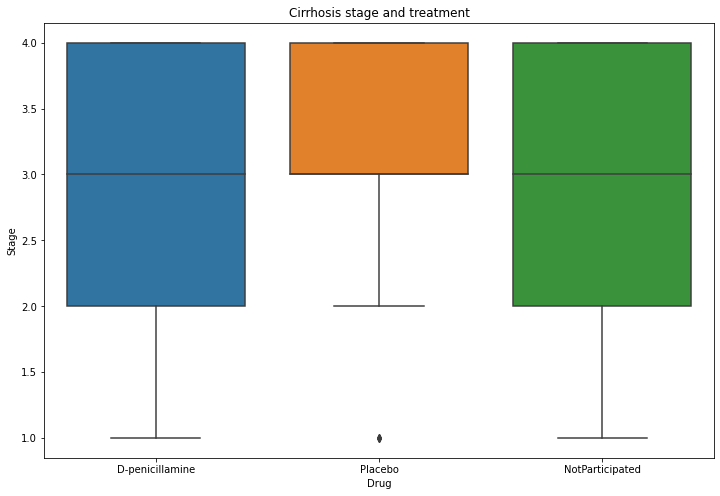

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Cirrhosis stage and treatment')
sns.boxplot(x=temp_df['Drug'], y=temp_df['Stage']);

*First inspection: Those who  use Placebo tend to have illness progression*

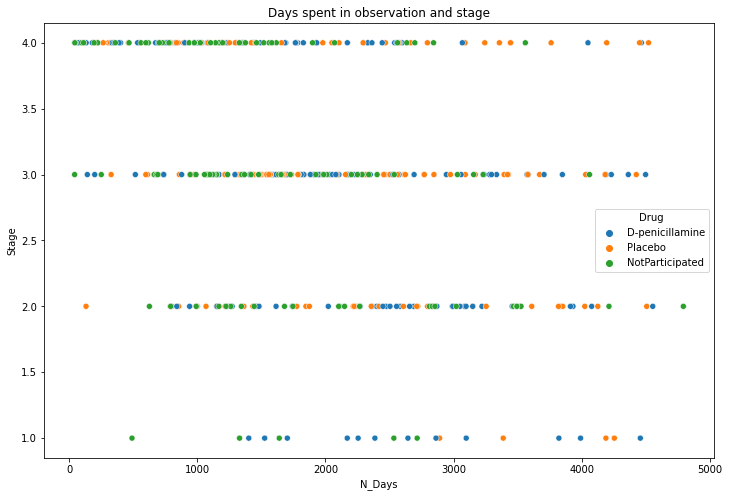

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Days spent in observation and stage')
sns.scatterplot(x=temp_df['N_Days'], y=temp_df['Stage'], hue=temp_df['Drug']);

*not informative plot*

In [ ]:
temp_df['Sex'].value_counts()

F    374
M     44
Name: Sex, dtype: int64

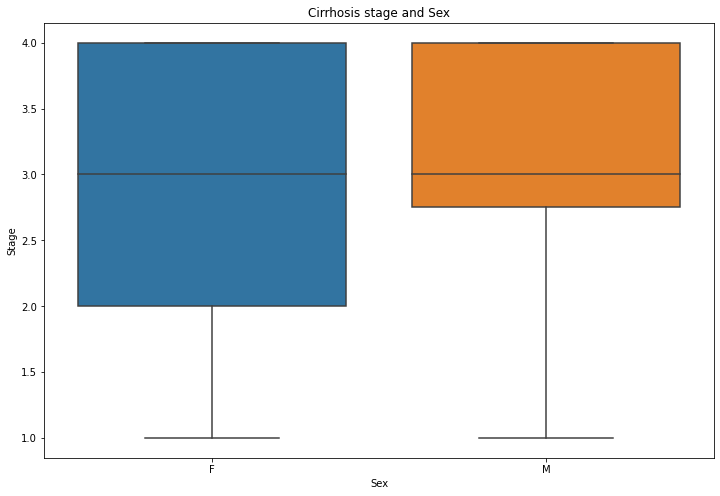

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Cirrhosis stage and Sex')
sns.boxplot(x=temp_df['Sex'], y=temp_df['Stage']);

*not informative (disbalanced)*

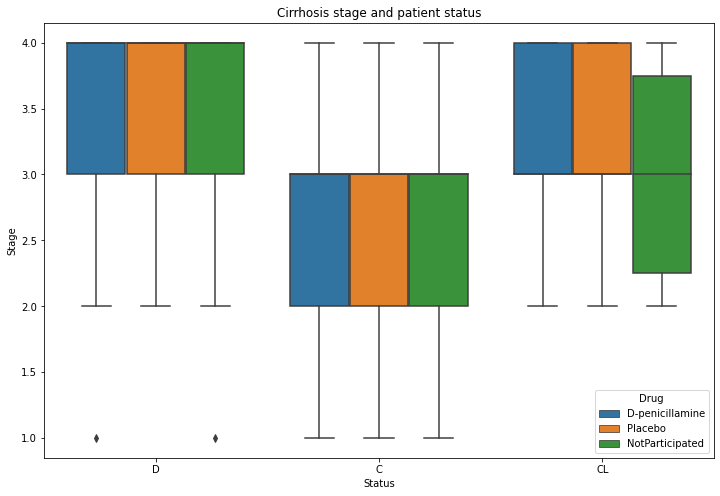

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Cirrhosis stage and patient status')
sns.boxplot(x=temp_df['Status'], y=temp_df['Stage'], hue=temp_df['Drug']);

*STATUS????*

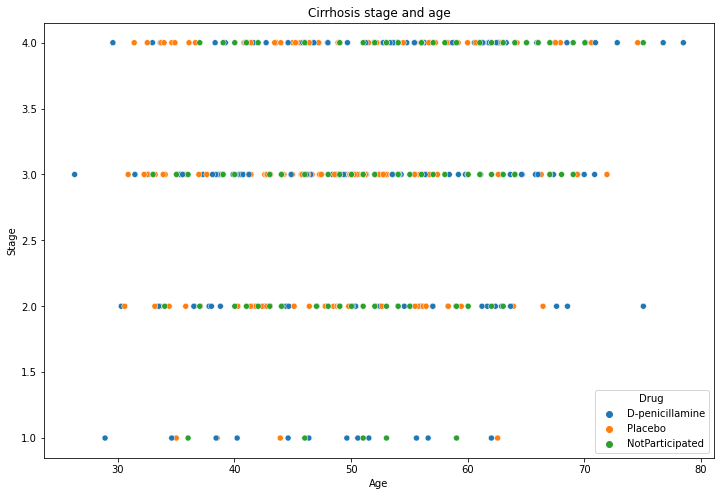

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Cirrhosis stage and age')
sns.scatterplot(x=temp_df['Age'] / 365, y=temp_df['Stage'], hue=temp_df['Drug']);

In [ ]:
temp_df['Age'].mean() / 365

50.776305957920954

In [ ]:
temp_df['Stage'].value_counts()

3    160
4    145
2     92
1     21
Name: Stage, dtype: int64

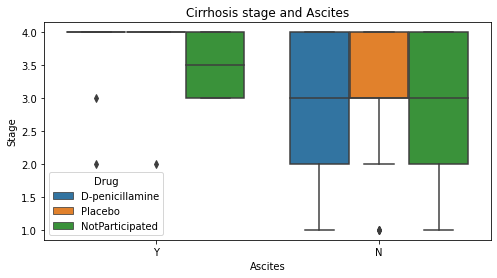

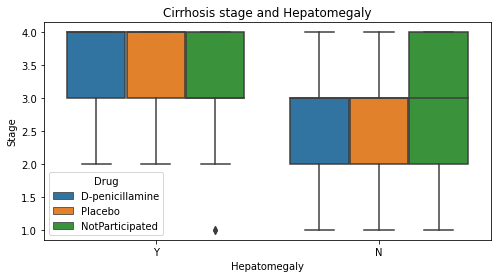

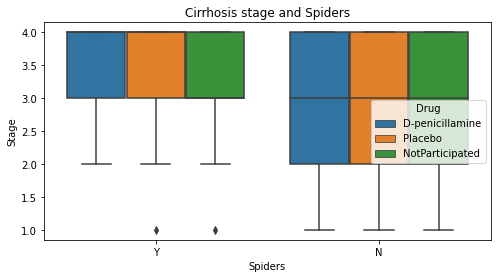

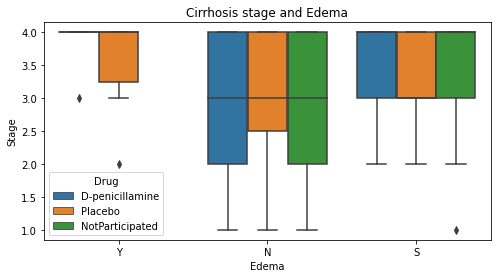

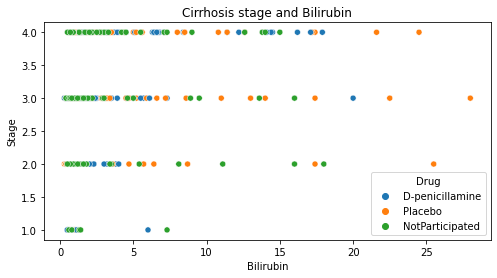

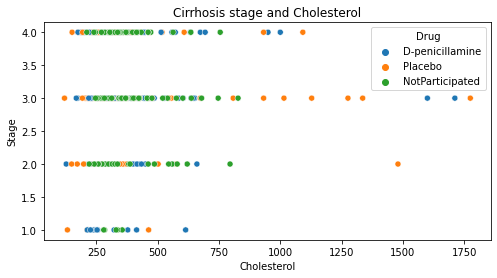

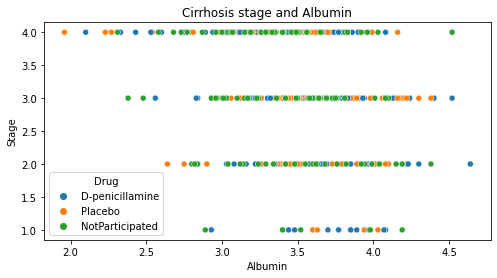

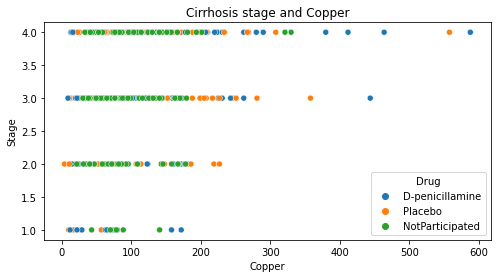

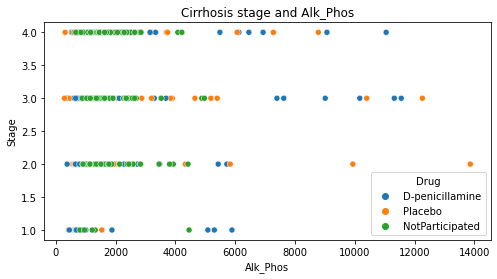

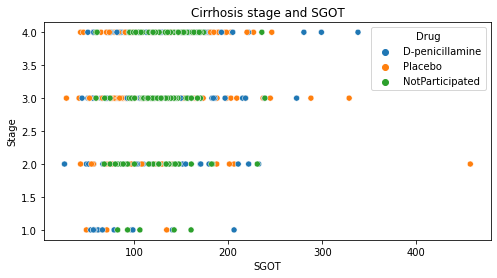

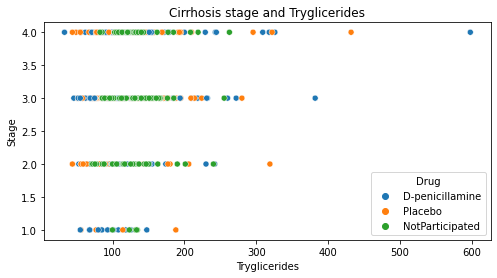

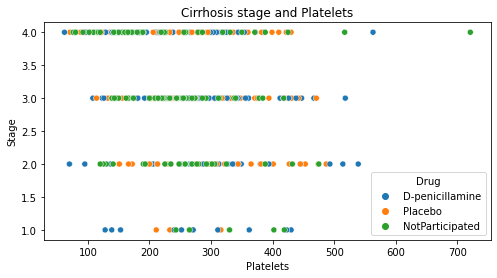

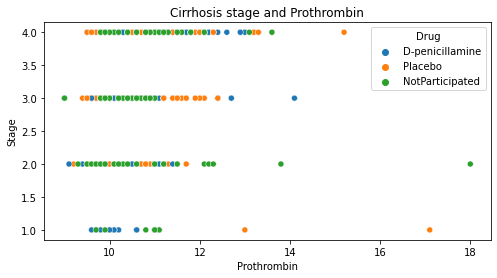

In [ ]:
diseases = list(temp_df.iloc[:,6:-1].columns)

for d in diseases:
    if temp_df[d].dtype == 'object':
        plt.figure(figsize=(8,4))
        name = 'Cirrhosis stage and ' + str(d)
        plt.title(name)
        sns.boxplot(x=temp_df[d], y=temp_df['Stage'], hue=temp_df['Drug']);
    else:
        plt.figure(figsize=(8,4))
        name = 'Cirrhosis stage and ' + str(d)
        plt.title(name)
        sns.scatterplot(x=temp_df[d], y=temp_df['Stage'], hue=temp_df['Drug']);

***So one can observe relations between features and target. It might be some outliers in bilirium, chole., copper, alk_ph columns.***

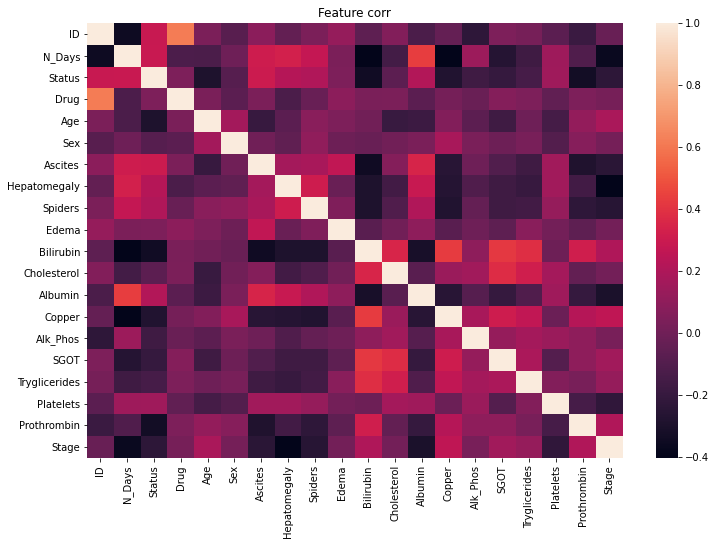

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Feature corr')
sns.heatmap(df.corr());

*ID column can be dropped, but let`s leave it*

In [ ]:
#df = df.drop('ID', axis=1)

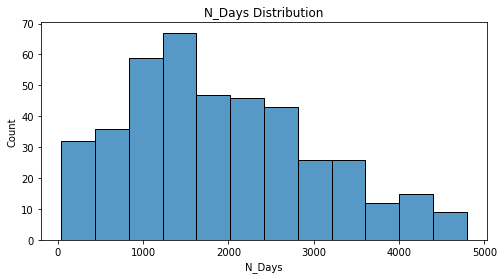

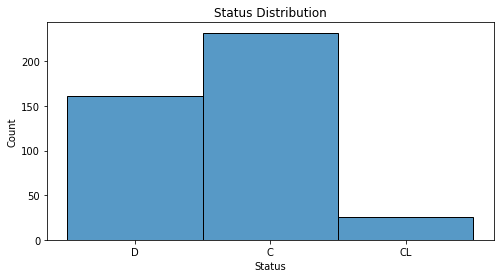

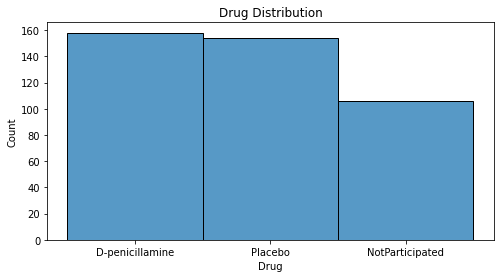

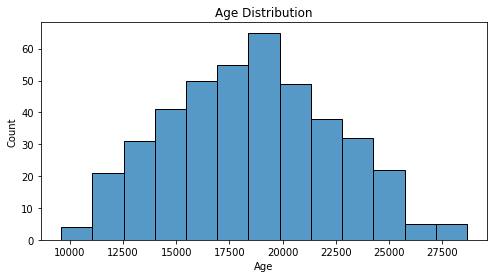

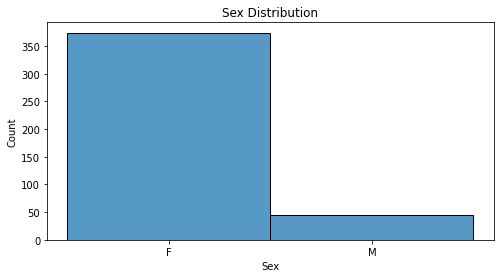

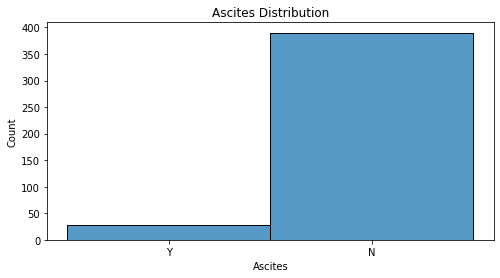

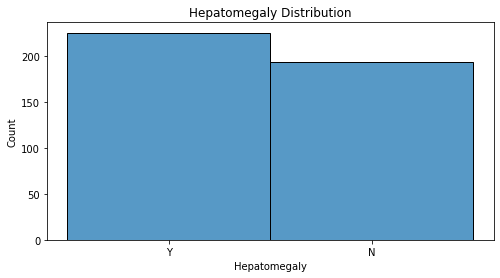

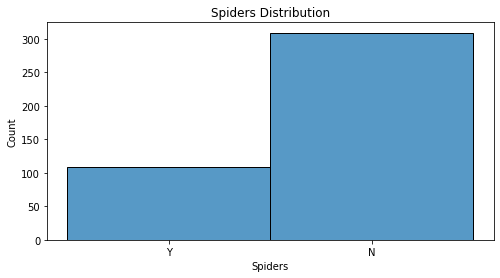

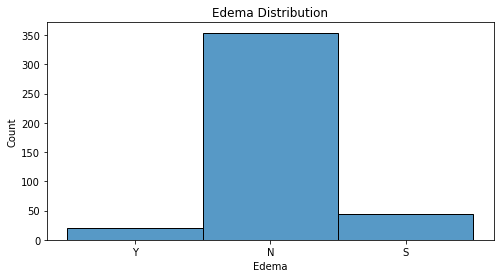

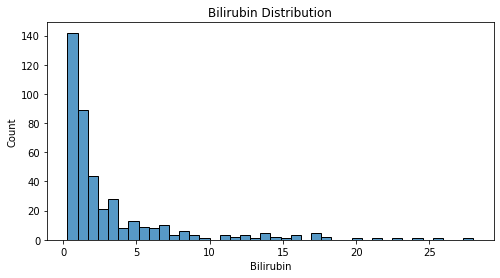

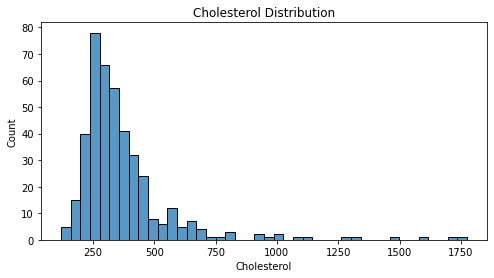

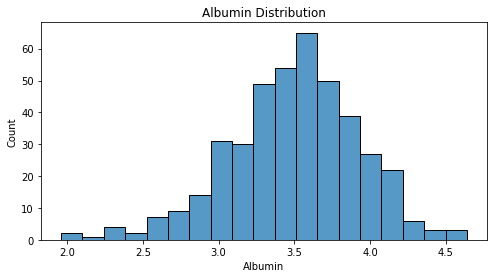

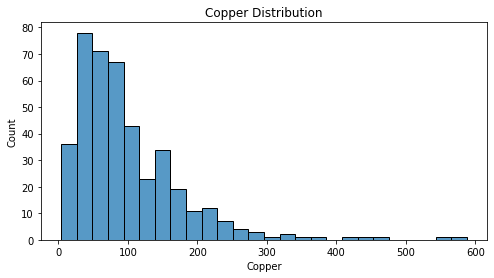

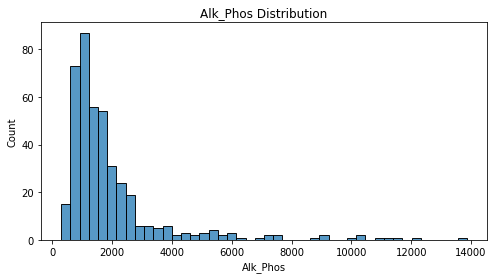

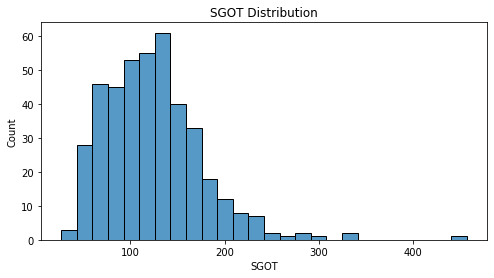

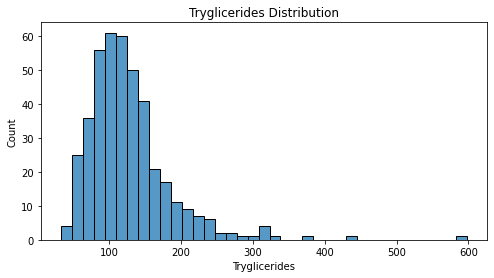

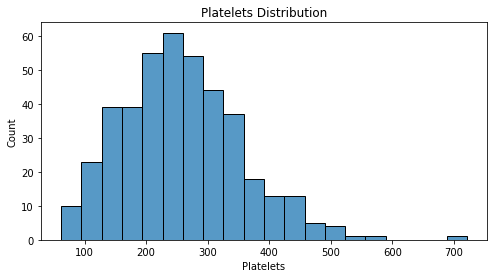

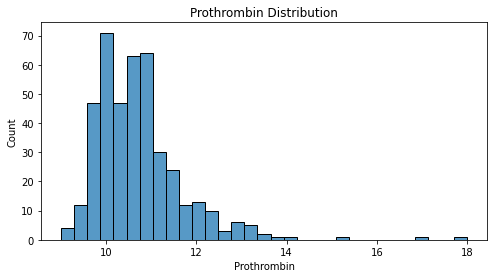

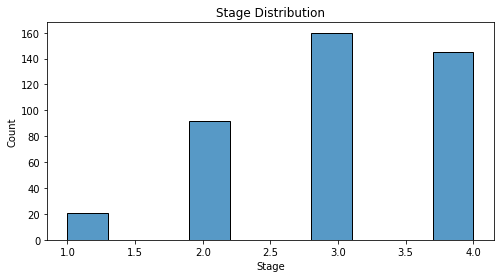

In [ ]:
 for col in list(temp_df.iloc[:,1:].columns):
        plt.figure(figsize=(8, 4))
        name = str(col) + ' Distribution'
        plt.title(name)
        sns.histplot(temp_df[col]);

**Log features transform**

In [ ]:
df

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1.0,400.0,0.0,0.0,21464.0,0.0,0.000000,0.000000,0.000000,0.0,14.5,261.000000,2.60,156.000000,1718.000000,137.950000,172.000000,190.0,12.2,4.0
1,2.0,4500.0,1.0,0.0,20617.0,0.0,1.000000,0.000000,0.000000,1.0,1.1,302.000000,4.14,54.000000,7394.800000,113.520000,88.000000,221.0,10.6,3.0
2,3.0,1012.0,0.0,0.0,25594.0,1.0,1.000000,1.000000,1.000000,2.0,1.4,176.000000,3.48,210.000000,516.000000,96.100000,55.000000,151.0,12.0,4.0
3,4.0,1925.0,0.0,0.0,19994.0,0.0,1.000000,0.000000,0.000000,2.0,1.8,244.000000,2.54,64.000000,6121.800000,60.630000,92.000000,183.0,10.3,4.0
4,5.0,1504.0,2.0,1.0,13918.0,0.0,1.000000,0.000000,0.000000,1.0,3.4,279.000000,3.53,143.000000,671.000000,113.150000,72.000000,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414.0,681.0,0.0,2.0,24472.0,0.0,1.000000,0.000000,1.000000,1.0,1.2,353.747554,2.96,170.173732,2353.868796,129.569139,150.902495,174.0,10.9,3.0
414,415.0,1103.0,1.0,2.0,14245.0,0.0,1.000000,0.704035,0.704035,1.0,0.9,370.675231,3.83,76.529851,1629.491494,120.441195,113.102982,180.0,11.2,4.0
415,416.0,1055.0,1.0,2.0,20819.0,0.0,1.000000,0.411286,0.703000,1.0,1.6,369.444909,3.42,131.600422,1150.968947,115.091120,98.996532,143.0,9.9,3.0
416,417.0,691.0,1.0,2.0,21185.0,0.0,1.000000,0.773832,1.000000,1.0,0.8,476.672185,3.75,162.866197,1356.202516,128.867778,95.997395,269.0,10.4,3.0


In [ ]:
columns = ['Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
for col in columns:
    temp_df[col] = temp_df[col].apply(lambda x: np.log(x + 1))
    df[col] = df[col].apply(lambda x: np.log(x + 1))

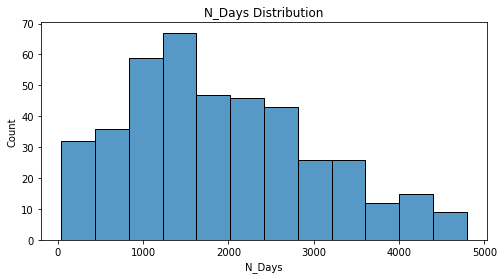

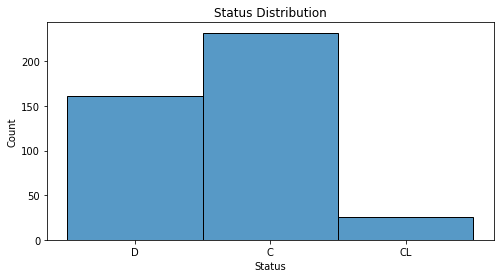

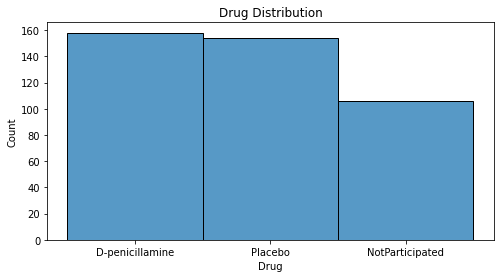

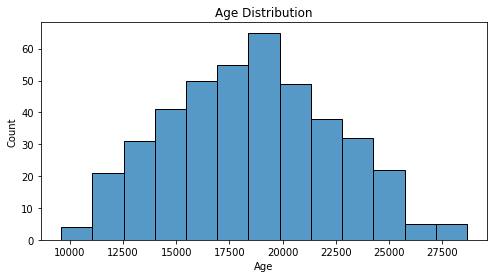

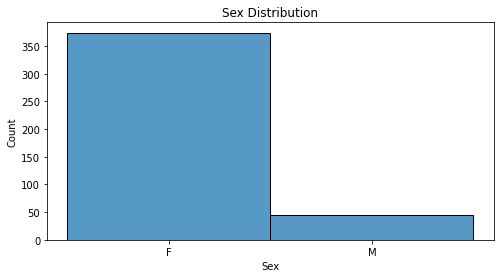

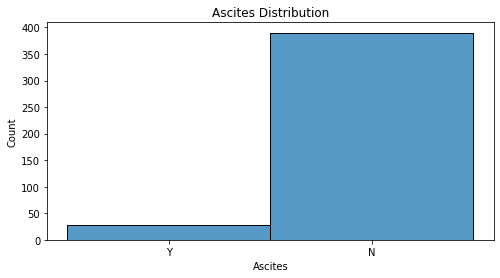

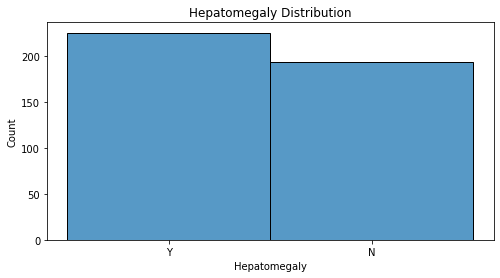

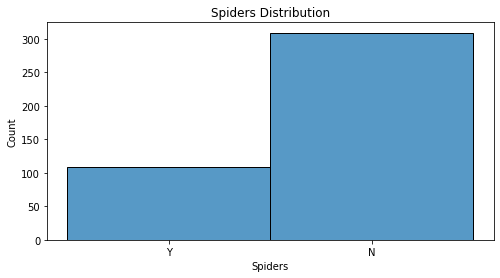

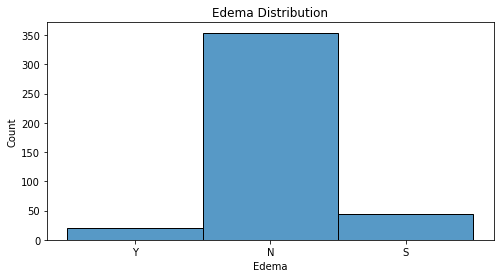

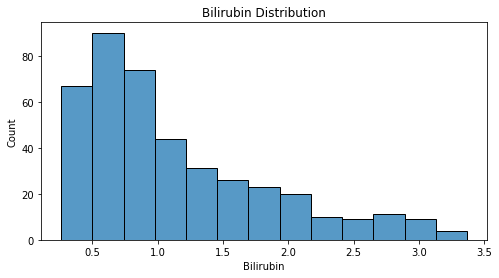

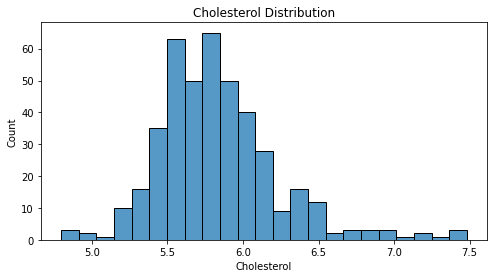

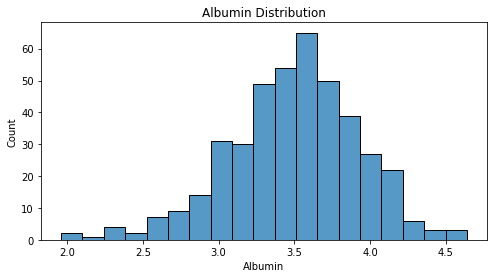

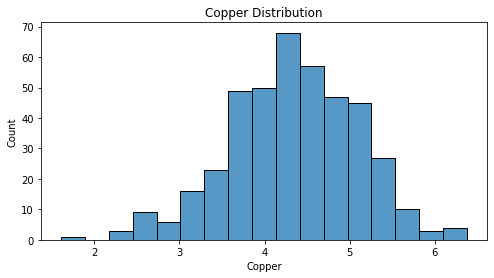

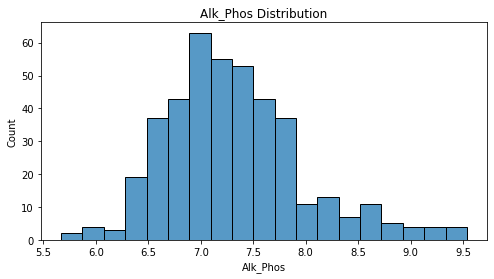

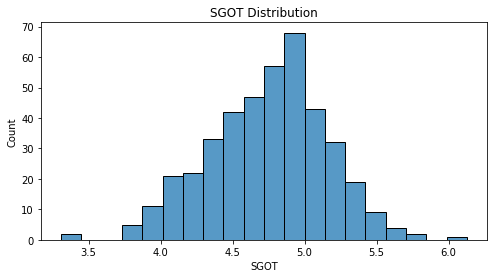

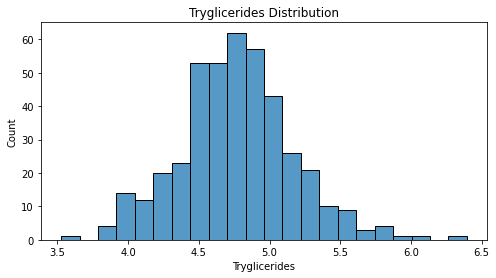

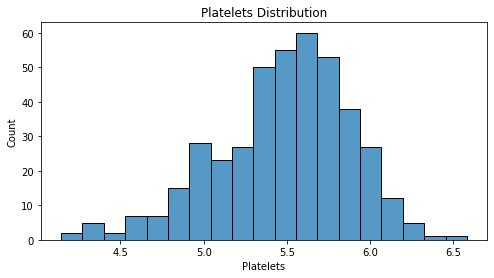

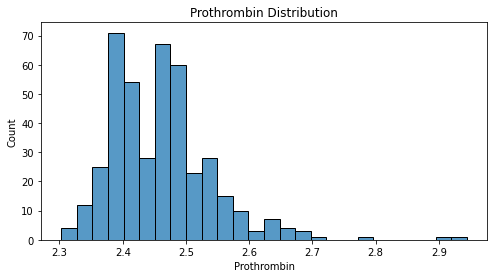

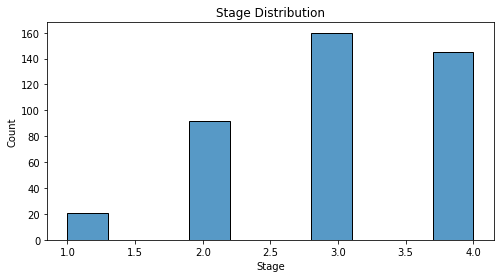

In [ ]:
 for col in list(temp_df.iloc[:,1:].columns):
        plt.figure(figsize=(8, 4))
        name = str(col) + ' Distribution'
        plt.title(name)
        sns.histplot(temp_df[col]);

# Handling Outliers

In [ ]:
def remove_outliers(df, column_list):
    for col in column_list:
        Q1 = np.quantile(df[col], 0.25)
        Q3 = np.quantile(df[col], 0.75)
        IQR = Q3 - Q1
        
        drop_outliers = [x for x in df[col] if (
        (x > Q1 - 1.5 * IQR) & (x < Q3 + 1.5 * IQR))]
        df = df.loc[df[col].isin(drop_outliers)]
    return df

# Scaling

In [ ]:
X, y = df.drop('Stage', axis=1), df['Stage']
y = y.apply(int)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X.shape

(418, 19)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=17)

# Models

So we faced problem of making decision which approach is better.  
1. We can treat outliers performing log transform, deleting observation using quantiles or just leave them;  
2. We can drop or leave *'ID'* column; 
3. We can use floating encoding for categorical features or just round them.  


Let`s try each combination of possible data preparation while training models. It will take some time, but results may surprise.

**models**:
1. LogReg;
2. LogReg with cross-validation;
3. KNN;
4. KNN with cross-validation;
5. SVM;
6. SVM with cross-validation;
7. RandomForest;
8. RandomForest with cross-validation;
9. GradientBoosting;
10. GradientBoosting with cross-validation.

*Cross-Validation* will be using scoring 'roc_auc_ovo' and 5 fields

In [ ]:
def add_performance_to_df(df_name, name_model, model, train_X, train_y, test_X, test_y):
    adder = {'model' : '', 'train_roc_auc_score_ovo': '', 'train_roc_auc_score_ovr': '',
             'test_roc_auc_score_ovo': '', 'test_roc_auc_score_ovr': ''}
    
    train_proba_predictions = model.predict_proba(train_X)
    test_proba_predictions = model.predict_proba(test_X)
    
    adder['model'] = name_model
    adder['train_roc_auc_score_ovo'] = roc_auc_score(y_true=train_y, y_score = train_proba_predictions, average='macro', multi_class='ovo')
    adder['train_roc_auc_score_ovr'] = roc_auc_score(y_true=train_y, y_score = train_proba_predictions, average='macro', multi_class='ovr')
    adder['test_roc_auc_score_ovo'] = roc_auc_score(y_true=test_y, y_score = test_proba_predictions, average='macro', multi_class='ovo')
    adder['test_roc_auc_score_ovr'] = roc_auc_score(y_true=test_y, y_score = test_proba_predictions, average='macro', multi_class='ovr')
    
    
    return df_name.append(adder, ignore_index=True)


def get_models_performance(models, X_train, y_train, X_test, y_test):
    cols = ['model', 'train_roc_auc_score_ovo', 'train_roc_auc_score_ovr', 
            'test_roc_auc_score_ovo', 'test_roc_auc_score_ovr']
    
    model_performance = pd.DataFrame(columns=cols)

    for key in models:
        model_performance = add_performance_to_df(model_performance, key, models[key],
                                                  X_train, y_train, X_test, y_test)
    return model_performance

**Functions that make stats for models performance**

In [ ]:
def data_prep(outliers_treatment=None, drop_id=False, floating_cat_features_encoding=False):
    data = pd.read_csv('../input/cirrhosis-prediction-dataset/cirrhosis.csv')
    data['Drug'] = data['Drug'].fillna('NotParticipated')
    data, decoder = encode_with_nan(data)
    data = knn_imputer2df(data)
    
    if not floating_cat_features_encoding:
        data = round_encoded_cat_features(data, decoder)
    
    if outliers_treatment == 'log':
        columns = ['Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
        for col in columns:
            data[col] = data[col].apply(lambda x: np.log(x + 1))
    
    if outliers_treatment == 'IQR':
        columns = ['Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
        data = remove_outliers(data, columns)
        
    
    if drop_id:
        data = data.drop('ID', axis=1)
        
    X, y = data.drop('Stage', axis=1), data['Stage']
    y = y.apply(int)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

In [ ]:
def pipeline(outliers_treatment=None, drop_id=False, floating_cat_features_encoding=False):
    X_scaled, y = data_prep(outliers_treatment=outliers_treatment, drop_id=drop_id, floating_cat_features_encoding=floating_cat_features_encoding)
    print('X shape: ', X_scaled.shape, ' y shape: ', y.shape)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=17)
    
    # lr
    lr = LogisticRegression(random_state=17)
    lr.fit(X_train, y_train)
    # ----------------------------------

    # lr_gcv
    lr_params = {'solver': ['sag', 'saga', 'liblinear'],
                 'C': np.logspace(-3, 1, 5),
                 'penalty': ['l1', 'l2', 'elasticnet'],
                 'class_weight': ['balanced', None]
                }

    lr_gcv = GridSearchCV(estimator=LogisticRegression(random_state=17), param_grid=lr_params, scoring='roc_auc_ovo', cv=5, verbose=True, n_jobs=-1)
    lr_gcv.fit(X_train, y_train)
    best_lr = lr_gcv.best_estimator_
    # -----------------------------
    
    # knn
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    # --------------------------
    
    # knn_gcv
    knn_params = {'n_neighbors': range(2, 8),
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree'], 
              'p': range(1, 5)}

    knn_gcv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_params,  scoring='roc_auc_ovo', cv=5, verbose=True, n_jobs=-1)
    knn_gcv.fit(X_train, y_train)
    best_knn = knn_gcv.best_estimator_
    # --------------------
    
    # svm
    svm = SVC(probability=True, random_state=17)
    svm.fit(X_train, y_train)
    # --------------------
    
    # svm_gcv
    svm_params = {'C': np.logspace(-4, 1, 6),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'class_weight': ['balanced', None]}

    svm_gcv = GridSearchCV(estimator=SVC(random_state=17, probability=True), param_grid=svm_params, scoring='roc_auc_ovo', cv=5, verbose=True, n_jobs=-1)
    svm_gcv.fit(X_train, y_train)
    best_svm = svm_gcv.best_estimator_
    # -----------------------

    # rf
    rf = RandomForestClassifier(random_state=17)
    rf.fit(X_train, y_train)
    # ------------------------------------

    # rf_gcv
    rf_params = {'n_estimators': range(20, 120, 20),
                 'criterion': ['gini', 'entropy'],
                 'min_samples_split': range(2, 8, 2),
                 'min_samples_leaf': range(1, 5),
                 'class_weight': ['balanced', 'balanced_subsample', None]}


    rf_gcv = GridSearchCV(estimator=RandomForestClassifier(random_state=17), param_grid=rf_params, scoring='roc_auc_ovo', cv=5, verbose=True, n_jobs=-1)
    rf_gcv.fit(X_train, y_train)
    best_rf = rf_gcv.best_estimator_
    # ----------------------------

    # gb
    gb = GradientBoostingClassifier(random_state=17)
    gb.fit(X_train, y_train)
    # ----------------------------

    # gb_gcv
    gb_params = {'loss': ['deviance', 'exponential'],
                 'learning_rate': np.logspace(-4, 1, 4),
                 'n_estimators': range(60, 160, 20),
                 'min_samples_split': range(2, 8, 2),
                 'min_samples_leaf': range(1, 5),
                 'max_features': ['sqrt', 'log2']}


    gb_gcv = GridSearchCV(estimator=GradientBoostingClassifier(random_state=17), param_grid=gb_params, scoring='roc_auc_ovo', cv=5, verbose=True, n_jobs=-1)
    gb_gcv.fit(X_train, y_train)
    best_gb = gb_gcv.best_estimator_

    
    lr = {'LogReg': lr}
    best_lr = {'LogReg_CV': best_lr}
    knn = {'KNN': knn}
    best_knn = {'KNN-CV': best_knn}
    svm = {'SVM': svm}
    best_svm = {'SVM-CV': best_svm}
    rf = {'RandomForest': rf}
    best_rf = {'RandomForest_CV': best_rf}
    gb = {'GradBoost': gb}
    best_gb =  {'GradBoost_CV': best_gb}
    
    models = {**lr, **best_lr, **knn, **best_knn, **svm, **best_svm, **rf, **best_rf, **gb, **best_gb}
    
    print('making perform...')
    model_performance = get_models_performance(models=models, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    print('Perform ready')
    return model_performance, models

In [ ]:
outliers = ['log', 'IQR', None]
drop_id = [False, True]
fcfe = [False, True]
combinations = list(product(outliers, drop_id, fcfe))
combinations

[('log', False, False),
 ('log', False, True),
 ('log', True, False),
 ('log', True, True),
 ('IQR', False, False),
 ('IQR', False, True),
 ('IQR', True, False),
 ('IQR', True, True),
 (None, False, False),
 (None, False, True),
 (None, True, False),
 (None, True, True)]

1. We ll test any possible combinations of preprocess steps and compare models results. Then will choose best approach of data prep

In [ ]:
perf_n_models = []
for combo in tqdm(combinations):
    print(combo)
    perf_n_models.append(pipeline(*combo))

  0%|          | 0/12 [00:00<?, ?it/s]

('log', False, False)
X shape:  (418, 19)  y shape:  (418,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.6min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1628 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4682 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.8min finished


making perform...


  8%|▊         | 1/12 [07:34<1:23:15, 454.13s/it]

Perform ready
('log', False, True)
X shape:  (418, 19)  y shape:  (418,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.1s finished


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.6min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2514 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.9min finished


making perform...


 17%|█▋        | 2/12 [15:15<1:16:26, 458.64s/it]

Perform ready
('log', True, False)
X shape:  (418, 18)  y shape:  (418,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.1s finished


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.6min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2673 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.8min finished


making perform...


 25%|██▌       | 3/12 [22:51<1:08:36, 457.37s/it]

Perform ready
('log', True, True)
X shape:  (418, 18)  y shape:  (418,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.2s finished


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.6min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2740 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.9min finished


making perform...


 33%|███▎      | 4/12 [30:31<1:01:05, 458.23s/it]

Perform ready
('IQR', False, False)
X shape:  (271, 19)  y shape:  (271,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.5min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 2673 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.3min finished


making perform...


 42%|████▏     | 5/12 [37:24<51:33, 441.99s/it]  

Perform ready
('IQR', False, True)
X shape:  (271, 19)  y shape:  (271,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.5min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 2752 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.3min finished


making perform...


 50%|█████     | 6/12 [44:15<43:08, 431.48s/it]

Perform ready
('IQR', True, False)
X shape:  (271, 18)  y shape:  (271,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.5min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 2514 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.3min finished


making perform...


 58%|█████▊    | 7/12 [51:10<35:29, 425.92s/it]

Perform ready
('IQR', True, True)
X shape:  (271, 18)  y shape:  (271,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 347 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.5min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 2514 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.4min finished


making perform...


 67%|██████▋   | 8/12 [58:07<28:12, 423.06s/it]

Perform ready
(None, False, False)
X shape:  (418, 19)  y shape:  (418,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.1s finished


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.6min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2514 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.9min finished


making perform...


 75%|███████▌  | 9/12 [1:05:47<21:44, 434.74s/it]

Perform ready
(None, False, True)
X shape:  (418, 19)  y shape:  (418,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.2s finished


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.6min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2740 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  6.0min finished


making perform...


 83%|████████▎ | 10/12 [1:13:34<14:49, 444.65s/it]

Perform ready
(None, True, False)
X shape:  (418, 18)  y shape:  (418,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.1s finished


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.6min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2596 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3239 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.8min finished


making perform...


 92%|█████████▏| 11/12 [1:21:08<07:27, 447.48s/it]

Perform ready
(None, True, True)
X shape:  (418, 18)  y shape:  (418,)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.3s finished


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.6min finished


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2514 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.9min finished


making perform...


100%|██████████| 12/12 [1:28:49<00:00, 444.14s/it]

Perform ready


## Finding Optimal Approach

Let`s look at descriptive statistics 

In [ ]:
# ('log', False, False)
perf_n_models[0][0]

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.770956,0.786433,0.694362,0.722792
1,LogReg_CV,0.706140,0.740837,0.693559,0.736127
2,KNN,0.845245,0.856025,0.631753,0.645629
3,KNN-CV,1.000000,1.000000,0.639213,0.653755
4,SVM,0.696431,0.764289,0.700565,0.762332
5,SVM-CV,0.695328,0.742014,0.659046,0.713893
6,RandomForest,1.000000,1.000000,0.713390,0.742249
7,RandomForest_CV,0.999849,0.999799,0.717409,0.740853
8,GradBoost,1.000000,1.000000,0.719803,0.732672
9,GradBoost_CV,1.000000,1.000000,0.705561,0.731517


In [ ]:
perf_n_models[0][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.871395,0.888940,0.687466,0.718182
std,0.142342,0.121233,0.032383,0.038307
min,0.695328,0.740837,0.631753,0.645629
25%,0.722344,0.769825,0.667675,0.716117
50%,0.922547,0.927912,0.697463,0.732094
75%,1.000000,1.000000,0.711433,0.739672
max,1.000000,1.000000,0.719803,0.762332


In [ ]:
#  ('log', False, True),
perf_n_models[1][0]

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.779685,0.793467,0.714634,0.741486
1,LogReg_CV,0.724788,0.748178,0.721911,0.753489
2,KNN,0.843395,0.855822,0.611770,0.629183
3,KNN-CV,1.000000,1.000000,0.644655,0.657144
4,SVM,0.737351,0.806039,0.702592,0.761989
5,SVM-CV,0.740483,0.804738,0.641934,0.705954
6,RandomForest,1.000000,1.000000,0.745175,0.767444
7,RandomForest_CV,0.998456,0.998810,0.737145,0.753548
8,GradBoost,1.000000,1.000000,0.735621,0.757822
9,GradBoost_CV,0.922669,0.929238,0.748286,0.779441


In [ ]:
perf_n_models[1][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.874683,0.893629,0.700372,0.730750
std,0.122055,0.102451,0.049373,0.050472
min,0.724788,0.748178,0.611770,0.629183
25%,0.750284,0.805063,0.659139,0.714837
50%,0.883032,0.892530,0.718273,0.753519
75%,0.999614,0.999703,0.736764,0.760948
max,1.000000,1.000000,0.748286,0.779441


In [ ]:
# ('log', True, False),
perf_n_models[2][0]

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.759244,0.773985,0.681607,0.713177
1,LogReg_CV,0.695548,0.736250,0.679538,0.725602
2,KNN,0.841633,0.852973,0.670225,0.681837
3,KNN-CV,0.824832,0.839310,0.662028,0.677207
4,SVM,0.659435,0.727335,0.708502,0.768309
5,SVM-CV,0.690896,0.738175,0.651995,0.708450
6,RandomForest,1.000000,1.000000,0.745897,0.758708
7,RandomForest_CV,0.997785,0.998498,0.747555,0.762625
8,GradBoost,1.000000,1.000000,0.664200,0.680173
9,GradBoost_CV,0.910664,0.921157,0.734744,0.762418


In [ ]:
perf_n_models[2][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.838004,0.858768,0.694629,0.723851
std,0.134786,0.114377,0.036561,0.037096
min,0.659435,0.727335,0.651995,0.677207
25%,0.711472,0.747127,0.665706,0.688490
50%,0.833232,0.846141,0.680573,0.719390
75%,0.976005,0.979163,0.728183,0.761490
max,1.000000,1.000000,0.747555,0.768309


In [ ]:
# ('log', True, True),
perf_n_models[3][0]

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.767365,0.780597,0.699238,0.730932
1,LogReg_CV,0.734105,0.739025,0.755120,0.757106
2,KNN,0.836550,0.849915,0.641617,0.653954
3,KNN-CV,1.000000,1.000000,0.660956,0.665110
4,SVM,0.689089,0.761717,0.713831,0.771083
5,SVM-CV,0.730808,0.794399,0.636336,0.699628
6,RandomForest,1.000000,1.000000,0.745292,0.772366
7,RandomForest_CV,0.998226,0.997176,0.724462,0.736535
8,GradBoost,1.000000,1.000000,0.682727,0.705327
9,GradBoost_CV,0.918707,0.925857,0.726995,0.757107


In [ ]:
perf_n_models[3][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.867485,0.884868,0.698658,0.724915
std,0.129818,0.110943,0.041999,0.042508
min,0.689089,0.739025,0.636336,0.653954
25%,0.742420,0.784047,0.666399,0.701053
50%,0.877628,0.887886,0.706535,0.733733
75%,0.999556,0.999294,0.726362,0.757107
max,1.000000,1.000000,0.755120,0.772366


In [ ]:
#('IQR', False, False),
perf_n_models[4][0]


,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.841026,0.830871,0.704965,0.711150
1,LogReg_CV,0.798503,0.764139,0.703171,0.699263
2,KNN,0.860825,0.857324,0.592684,0.609212
3,KNN-CV,1.000000,1.000000,0.633045,0.649525
4,SVM,0.898476,0.888542,0.641767,0.689013
5,SVM-CV,0.712752,0.746160,0.645745,0.690152
6,RandomForest,1.000000,1.000000,0.669582,0.689668
7,RandomForest_CV,1.000000,1.000000,0.687092,0.703751
8,GradBoost,1.000000,1.000000,0.679028,0.690094
9,GradBoost_CV,0.981285,0.977449,0.688005,0.710458


In [ ]:
perf_n_models[4][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.909287,0.906448,0.664508,0.684229
std,0.103346,0.102436,0.035665,0.031577
min,0.712752,0.746160,0.592684,0.609212
25%,0.845976,0.837484,0.642761,0.689177
50%,0.939881,0.932995,0.674305,0.690123
75%,1.000000,1.000000,0.687776,0.702629
max,1.000000,1.000000,0.704965,0.711150


In [ ]:
#('IQR', False, True),
perf_n_models[5][0]

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.845361,0.838901,0.725814,0.730305
1,LogReg_CV,0.800932,0.766802,0.702976,0.699028
2,KNN,0.870485,0.867146,0.582794,0.600901
3,KNN-CV,1.000000,1.000000,0.629863,0.645268
4,SVM,0.873618,0.899289,0.670279,0.700104
5,SVM-CV,0.669595,0.678805,0.685674,0.706684
6,RandomForest,1.000000,1.000000,0.661440,0.684568
7,RandomForest_CV,0.998962,0.998813,0.683135,0.700239
8,GradBoost,1.000000,1.000000,0.683800,0.692577
9,GradBoost_CV,0.982554,0.979450,0.698982,0.721239


In [ ]:
perf_n_models[5][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.904151,0.902921,0.672476,0.688091
std,0.112492,0.114248,0.040660,0.038161
min,0.669595,0.678805,0.582794,0.600901
25%,0.851642,0.845962,0.663650,0.686570
50%,0.928086,0.939369,0.683467,0.699566
75%,0.999740,0.999703,0.695655,0.705072
max,1.000000,1.000000,0.725814,0.730305


In [ ]:
#('IQR', True, False),
perf_n_models[6][0]


,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.839554,0.824457,0.697064,0.700926
1,LogReg_CV,0.822196,0.784603,0.714184,0.701090
2,KNN,0.870852,0.860576,0.608868,0.621900
3,KNN-CV,1.000000,1.000000,0.648102,0.659620
4,SVM,0.887730,0.875773,0.645361,0.692820
5,SVM-CV,0.739536,0.765879,0.656179,0.700060
6,RandomForest,1.000000,1.000000,0.671074,0.685852
7,RandomForest_CV,0.999916,0.999869,0.630870,0.642241
8,GradBoost,1.000000,1.000000,0.692979,0.695414
9,GradBoost_CV,0.987681,0.984671,0.696750,0.715920


In [ ]:
perf_n_models[6][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.914746,0.909583,0.666143,0.681584
std,0.095424,0.097398,0.033874,0.030190
min,0.739536,0.765879,0.608868,0.621900
25%,0.847378,0.833487,0.646046,0.666178
50%,0.937705,0.930222,0.663627,0.694117
75%,0.999979,0.999967,0.695808,0.700709
max,1.000000,1.000000,0.714184,0.715920


In [ ]:
#('IQR', True, True),
perf_n_models[7][0]

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.841910,0.830248,0.713844,0.716925
1,LogReg_CV,0.825230,0.788635,0.710881,0.699191
2,KNN,0.878340,0.870206,0.597614,0.614321
3,KNN-CV,1.000000,1.000000,0.634691,0.645462
4,SVM,0.841738,0.868432,0.664813,0.696428
5,SVM-CV,0.795904,0.822447,0.693553,0.715915
6,RandomForest,1.000000,1.000000,0.662118,0.686985
7,RandomForest_CV,1.000000,1.000000,0.617413,0.639746
8,GradBoost,1.000000,1.000000,0.652599,0.660115
9,GradBoost_CV,0.989465,0.986451,0.696553,0.714862


In [ ]:
perf_n_models[7][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.917259,0.916642,0.664408,0.678995
std,0.087363,0.088110,0.039699,0.036618
min,0.795904,0.788635,0.597614,0.614321
25%,0.841781,0.839794,0.639168,0.649126
50%,0.933902,0.928329,0.663466,0.691707
75%,1.000000,1.000000,0.695803,0.710944
max,1.000000,1.000000,0.713844,0.716925


In [ ]:
#(None, False, False),
perf_n_models[8][0]

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.768893,0.784704,0.706630,0.733645
1,LogReg_CV,0.705672,0.741813,0.684373,0.730136
2,KNN,0.848930,0.861289,0.667645,0.682464
3,KNN-CV,0.829847,0.841208,0.646625,0.666036
4,SVM,0.757039,0.819322,0.687718,0.750189
5,SVM-CV,0.790719,0.851357,0.676024,0.723839
6,RandomForest,1.000000,1.000000,0.711386,0.740711
7,RandomForest_CV,0.999849,0.999799,0.708376,0.732682
8,GradBoost,1.000000,1.000000,0.719896,0.732494
9,GradBoost_CV,1.000000,1.000000,0.703933,0.731779


In [ ]:
perf_n_models[8][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.870095,0.889949,0.691260,0.722398
std,0.118269,0.100607,0.022990,0.026590
min,0.705672,0.741813,0.646625,0.666036
25%,0.774349,0.824794,0.678111,0.725413
50%,0.839389,0.856323,0.695825,0.732137
75%,0.999962,0.999950,0.707939,0.733404
max,1.000000,1.000000,0.719896,0.750189


In [ ]:
#(None, False, True),
perf_n_models[9][0]

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.777983,0.793054,0.720935,0.746453
1,LogReg_CV,0.711316,0.747373,0.690814,0.740559
2,KNN,0.849760,0.866447,0.658381,0.673699
3,KNN-CV,0.831254,0.844371,0.653471,0.672728
4,SVM,0.821956,0.874627,0.708961,0.755474
5,SVM-CV,0.791338,0.845650,0.680742,0.733012
6,RandomForest,1.000000,1.000000,0.740866,0.763078
7,RandomForest_CV,0.998482,0.998836,0.738952,0.756139
8,GradBoost,1.000000,1.000000,0.737625,0.758297
9,GradBoost_CV,0.922669,0.929238,0.748599,0.779701


In [ ]:
perf_n_models[9][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.870476,0.889959,0.707934,0.737914
std,0.103888,0.089546,0.035286,0.036381
min,0.711316,0.747373,0.653471,0.672728
25%,0.798992,0.844691,0.683260,0.734899
50%,0.840507,0.870537,0.714948,0.750964
75%,0.979529,0.981437,0.738620,0.757757
max,1.000000,1.000000,0.748599,0.779701


In [ ]:
#(None, True, False),
perf_n_models[10][0]

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.758622,0.772805,0.688267,0.720542
1,LogReg_CV,0.705627,0.741800,0.684373,0.730136
2,KNN,0.848028,0.861711,0.659584,0.671953
3,KNN-CV,0.834927,0.846470,0.681150,0.694461
4,SVM,0.742018,0.807101,0.697975,0.757584
5,SVM-CV,0.792701,0.851472,0.674644,0.723747
6,RandomForest,1.000000,1.000000,0.748634,0.761845
7,RandomForest_CV,0.997757,0.998457,0.745269,0.761587
8,GradBoost,1.000000,1.000000,0.661286,0.677013
9,GradBoost_CV,0.919378,0.927758,0.737166,0.767121


In [ ]:
perf_n_models[10][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.859906,0.880757,0.697835,0.726599
std,0.113055,0.096197,0.033773,0.035907
min,0.705627,0.741800,0.659584,0.671953
25%,0.767142,0.816943,0.676270,0.700981
50%,0.841477,0.856592,0.686320,0.726942
75%,0.978162,0.980782,0.727369,0.760586
max,1.000000,1.000000,0.748634,0.767121


In [ ]:
#(None, True, True)]
perf_n_models[11][0]

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.765043,0.779398,0.702094,0.735599
1,LogReg_CV,0.710309,0.746026,0.689566,0.738932
2,KNN,0.847329,0.864230,0.650990,0.662221
3,KNN-CV,0.824333,0.840468,0.679762,0.691324
4,SVM,0.792960,0.850922,0.714649,0.761704
5,SVM-CV,0.778899,0.836000,0.677643,0.731795
6,RandomForest,1.000000,1.000000,0.742348,0.770464
7,RandomForest_CV,0.997975,0.998424,0.762657,0.781433
8,GradBoost,1.000000,1.000000,0.679537,0.703685
9,GradBoost_CV,0.919092,0.926273,0.730353,0.759135


In [ ]:
perf_n_models[11][0].describe()

,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
count,10.000000,10.000000,10.000000,10.000000
mean,0.863594,0.884174,0.702960,0.733629
std,0.108284,0.092769,0.034336,0.037862
min,0.710309,0.746026,0.650990,0.662221
25%,0.782415,0.837117,0.679593,0.710713
50%,0.835831,0.857576,0.695830,0.737265
75%,0.978254,0.980386,0.726427,0.761061
max,1.000000,1.000000,0.762657,0.781433


In [ ]:
# ('log', False, True) mean: 0.700372, 0.730750;  min: 0.611770, 0.629183; max: 0.748286, 0.779441
# (None, True, True)   mean: 0.702960, 0.733629;  min: 0.650990, 0.662221; max: 0.762657, 0.781433

**So now we will try to increase models performance of two different approaches:**  
1. Log features transformation + with ID column + discrete encoding for categorical features
2. No outliers treatment + whithout ID column + discrete encoding for categorical features

# Building Ensemble Classifiers

## Blending

* Stacking-type ensemble where the meta-model is trained on predictions made on a holdout dataset.

In [ ]:
def df_for_blend(models, models_name, tr_X, te_X, tr_y, te_y):
    tr_blend_df = pd.DataFrame(columns=models_name) 
    te_blend_df = pd.DataFrame(columns=models_name)
    for model, name in zip(models, models_name):
        model.fit(tr_X, tr_y)
        train_pred = model.predict(tr_X)
        test_pred = model.predict(te_X)
        tr_blend_df[name] = train_pred
        te_blend_df[name] = test_pred
    return tr_blend_df, te_blend_df


def blend_clf(tr_blend_df, te_blend_df, tr_y, te_y):
    lr = LogisticRegression(solver='liblinear', random_state=17)
    lr.fit(tr_blend_df, tr_y)
    return lr

### first approach

In [ ]:
first_approach = perf_n_models[1][0].copy() # ('log', False, True)
first_approach

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.779685,0.793467,0.714634,0.741486
1,LogReg_CV,0.724788,0.748178,0.721911,0.753489
2,KNN,0.843395,0.855822,0.611770,0.629183
3,KNN-CV,1.000000,1.000000,0.644655,0.657144
4,SVM,0.737351,0.806039,0.702592,0.761989
5,SVM-CV,0.740483,0.804738,0.641934,0.705954
6,RandomForest,1.000000,1.000000,0.745175,0.767444
7,RandomForest_CV,0.998456,0.998810,0.737145,0.753548
8,GradBoost,1.000000,1.000000,0.735621,0.757822
9,GradBoost_CV,0.922669,0.929238,0.748286,0.779441


In [ ]:
X1_scaled, y1 = data_prep('log', False, True)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.33, random_state=17)

In [ ]:
models = [perf_n_models[1][1]['LogReg_CV'], perf_n_models[1][1]['KNN-CV'],
          perf_n_models[1][1]['SVM'], perf_n_models[1][1]['RandomForest'], perf_n_models[1][1]['GradBoost_CV']]

model_names = ['LogReg_CV', 'KNN-CV', 'SVM', 'RandomForest', 'GradBoost_CV']

tr_blend_df, te_blend_df = df_for_blend(models=models, models_name=model_names,
                                        tr_X=X1_train, te_X=X1_test, tr_y=y1_train, te_y=y1_test)

tr_blend_df


,LogReg_CV,KNN-CV,SVM,RandomForest,GradBoost_CV
0,3,2,3,2,3
1,3,4,3,4,3
2,4,4,4,4,3
3,3,3,3,3,3
4,3,3,3,3,3
...,...,...,...,...,...
275,4,3,3,3,3
276,4,2,3,2,3
277,4,3,3,3,3
278,4,3,3,3,3


* Are models correlated?

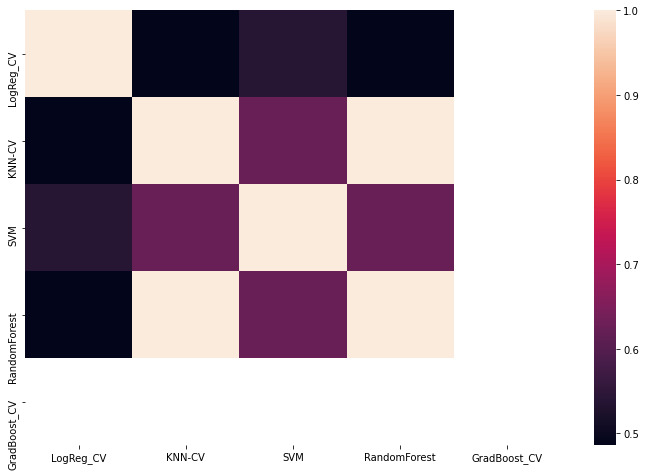

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(tr_blend_df.corr());

Gradient booosting has 1.0 corr with each model. So lets delete it.

In [ ]:
tr_blend_df, te_blend_df = tr_blend_df.drop('GradBoost_CV', axis=1), te_blend_df.drop('GradBoost_CV', axis=1)

In [ ]:
blend = blend_clf(tr_blend_df, te_blend_df, y1_train, y1_test)
first_approach = add_performance_to_df(perf_n_models[1][0], 'BlendingClassifier', blend, tr_blend_df, y1_train, te_blend_df, y1_test)
first_approach

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.779685,0.793467,0.714634,0.741486
1,LogReg_CV,0.724788,0.748178,0.721911,0.753489
2,KNN,0.843395,0.855822,0.611770,0.629183
3,KNN-CV,1.000000,1.000000,0.644655,0.657144
4,SVM,0.737351,0.806039,0.702592,0.761989
5,SVM-CV,0.740483,0.804738,0.641934,0.705954
6,RandomForest,1.000000,1.000000,0.745175,0.767444
7,RandomForest_CV,0.998456,0.998810,0.737145,0.753548
8,GradBoost,1.000000,1.000000,0.735621,0.757822
9,GradBoost_CV,0.922669,0.929238,0.748286,0.779441


**As we can see Blending does not improve score**

### second approach

In [ ]:
second_approach = perf_n_models[11][0] #(None, True, True)]
second_approach

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.765043,0.779398,0.702094,0.735599
1,LogReg_CV,0.710309,0.746026,0.689566,0.738932
2,KNN,0.847329,0.864230,0.650990,0.662221
3,KNN-CV,0.824333,0.840468,0.679762,0.691324
4,SVM,0.792960,0.850922,0.714649,0.761704
5,SVM-CV,0.778899,0.836000,0.677643,0.731795
6,RandomForest,1.000000,1.000000,0.742348,0.770464
7,RandomForest_CV,0.997975,0.998424,0.762657,0.781433
8,GradBoost,1.000000,1.000000,0.679537,0.703685
9,GradBoost_CV,0.919092,0.926273,0.730353,0.759135


In [ ]:
X2_scaled, y2 = data_prep(None, True, True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y2, test_size=0.33, random_state=17)

In [ ]:
models = [perf_n_models[11][1]['LogReg'], perf_n_models[11][1]['KNN-CV'],
          perf_n_models[11][1]['SVM'], perf_n_models[11][1]['RandomForest_CV'], perf_n_models[11][1]['GradBoost_CV']]

model_names = ['LogReg', 'KNN-CV', 'SVM', 'RandomForest_CV', 'GradBoost_CV']

tr_blend_df, te_blend_df = df_for_blend(models=models, models_name=model_names,
                                        tr_X=X2_train, te_X=X2_test, tr_y=y2_train, te_y=y2_test)

tr_blend_df


,LogReg,KNN-CV,SVM,RandomForest_CV,GradBoost_CV
0,3,3,3,2,3
1,3,3,3,4,3
2,4,4,4,4,3
3,3,3,3,3,3
4,3,3,3,3,3
...,...,...,...,...,...
275,3,3,3,3,3
276,3,3,3,2,3
277,3,3,3,3,3
278,4,3,3,3,3


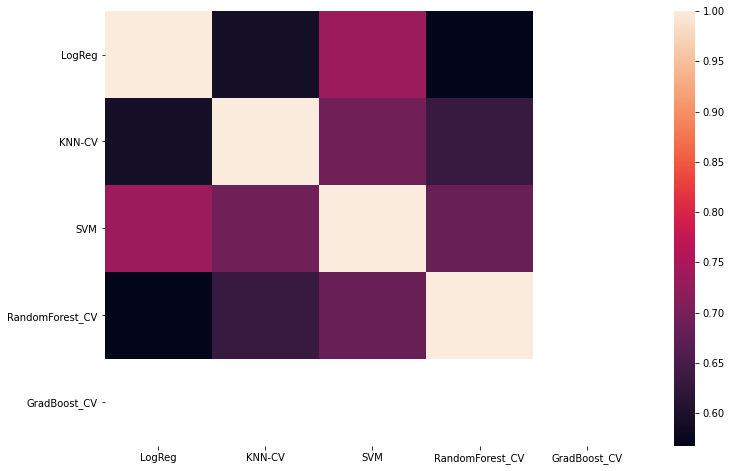

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(tr_blend_df.corr());

**In second approach gradboosting also highly corr**

In [ ]:
tr_blend_df, te_blend_df = tr_blend_df.drop('GradBoost_CV', axis=1), te_blend_df.drop('GradBoost_CV', axis=1)

In [ ]:
blend = blend_clf(tr_blend_df, te_blend_df, y2_train, y2_test)
second_approach = add_performance_to_df(second_approach, 'BlendingClassifier', blend, tr_blend_df, y2_train, te_blend_df, y2_test)
second_approach

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.765043,0.779398,0.702094,0.735599
1,LogReg_CV,0.710309,0.746026,0.689566,0.738932
2,KNN,0.847329,0.864230,0.650990,0.662221
3,KNN-CV,0.824333,0.840468,0.679762,0.691324
4,SVM,0.792960,0.850922,0.714649,0.761704
5,SVM-CV,0.778899,0.836000,0.677643,0.731795
6,RandomForest,1.000000,1.000000,0.742348,0.770464
7,RandomForest_CV,0.997975,0.998424,0.762657,0.781433
8,GradBoost,1.000000,1.000000,0.679537,0.703685
9,GradBoost_CV,0.919092,0.926273,0.730353,0.759135


**Here also blending performs very bad**

## Stacking 

* Stacking-type ensemble where the meta-model is trained on out-of-fold predictions made during k-fold cross-validation

In [ ]:
def stacking_clf(models, model_names, tr_X, tr_y):
    level0 = list()
    for model, name in zip(models, model_names):
        level0.append((name, model))
        
    level1 = LogisticRegression(C=0.001, class_weight='balanced', random_state=17, solver='liblinear')
    stcl = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, stack_method='predict_proba', passthrough=True, n_jobs=-1)
    stcl.fit(tr_X, tr_y)
    return stcl

### First approach

In [ ]:
model_names, models = list(perf_n_models[1][1].keys()), list(perf_n_models[1][1].values()),
stacking = stacking_clf(models, model_names, X1_train, y1_train)
first_approach = add_performance_to_df(first_approach, 'StackingClassifier', stacking, X1_train, y1_train, X1_test, y1_test)
first_approach

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.779685,0.793467,0.714634,0.741486
1,LogReg_CV,0.724788,0.748178,0.721911,0.753489
2,KNN,0.843395,0.855822,0.611770,0.629183
3,KNN-CV,1.000000,1.000000,0.644655,0.657144
4,SVM,0.737351,0.806039,0.702592,0.761989
5,SVM-CV,0.740483,0.804738,0.641934,0.705954
6,RandomForest,1.000000,1.000000,0.745175,0.767444
7,RandomForest_CV,0.998456,0.998810,0.737145,0.753548
8,GradBoost,1.000000,1.000000,0.735621,0.757822
9,GradBoost_CV,0.922669,0.929238,0.748286,0.779441


**Again stacking does not change a thing**

### Second Approach

In [ ]:
model_names, models = list(perf_n_models[11][1].keys()), list(perf_n_models[11][1].values()),
stacking = stacking_clf(models, model_names, X2_train, y2_train)
second_approach = add_performance_to_df(second_approach, 'StackingClassifier', stacking, X2_train, y2_train, X2_test, y2_test)
second_approach

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.765043,0.779398,0.702094,0.735599
1,LogReg_CV,0.710309,0.746026,0.689566,0.738932
2,KNN,0.847329,0.864230,0.650990,0.662221
3,KNN-CV,0.824333,0.840468,0.679762,0.691324
4,SVM,0.792960,0.850922,0.714649,0.761704
5,SVM-CV,0.778899,0.836000,0.677643,0.731795
6,RandomForest,1.000000,1.000000,0.742348,0.770464
7,RandomForest_CV,0.997975,0.998424,0.762657,0.781433
8,GradBoost,1.000000,1.000000,0.679537,0.703685
9,GradBoost_CV,0.919092,0.926273,0.730353,0.759135


**Here stacking shows mid score**

## Bagging

### First approach

In [ ]:
bagg = BaggingClassifier(base_estimator=perf_n_models[1][1]['GradBoost_CV'], random_state=17, bootstrap=True)
bagg.fit(X1_train, y1_train)
first_approach = add_performance_to_df(first_approach, 'BaggingClassifier(GradBoost)', bagg, X1_train, y1_train, X1_test, y1_test)
first_approach

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.779685,0.793467,0.714634,0.741486
1,LogReg_CV,0.724788,0.748178,0.721911,0.753489
2,KNN,0.843395,0.855822,0.611770,0.629183
3,KNN-CV,1.000000,1.000000,0.644655,0.657144
4,SVM,0.737351,0.806039,0.702592,0.761989
5,SVM-CV,0.740483,0.804738,0.641934,0.705954
6,RandomForest,1.000000,1.000000,0.745175,0.767444
7,RandomForest_CV,0.998456,0.998810,0.737145,0.753548
8,GradBoost,1.000000,1.000000,0.735621,0.757822
9,GradBoost_CV,0.922669,0.929238,0.748286,0.779441


**Bagging became as good as a simple gradient boosting**

### Second approach

In [ ]:
bagg = BaggingClassifier(base_estimator=perf_n_models[11][1]['RandomForest_CV'], random_state=17, bootstrap=True)
bagg.fit(X2_train, y2_train)
second_approach = add_performance_to_df(second_approach, 'BaggingClassifier(RandomForest_CV)', bagg, X2_train, y2_train, X2_test, y2_test)
second_approach

,model,train_roc_auc_score_ovo,train_roc_auc_score_ovr,test_roc_auc_score_ovo,test_roc_auc_score_ovr
0,LogReg,0.765043,0.779398,0.702094,0.735599
1,LogReg_CV,0.710309,0.746026,0.689566,0.738932
2,KNN,0.847329,0.864230,0.650990,0.662221
3,KNN-CV,0.824333,0.840468,0.679762,0.691324
4,SVM,0.792960,0.850922,0.714649,0.761704
5,SVM-CV,0.778899,0.836000,0.677643,0.731795
6,RandomForest,1.000000,1.000000,0.742348,0.770464
7,RandomForest_CV,0.997975,0.998424,0.762657,0.781433
8,GradBoost,1.000000,1.000000,0.679537,0.703685
9,GradBoost_CV,0.919092,0.926273,0.730353,0.759135


**So none of ensemble model helped to increase score**

### So the best score has RF_CV without any tratment of outliers, whithout ID column and with discrete encoding for categorical features

# Feature importance

In [ ]:
best_first_ap_model = perf_n_models[1][1]['GradBoost_CV']
the_best_second_ap_model = perf_n_models[11][1]['RandomForest_CV']

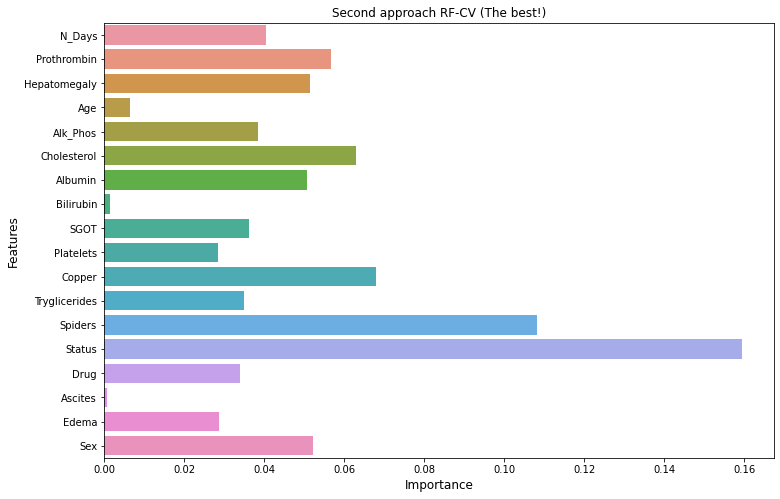

In [ ]:
plt.figure(figsize=(12, 8))


rf_indices = np.argsort(the_best_second_ap_model.feature_importances_)[::-1]


ax2 = sns.barplot(y=df.drop('ID', axis=1).columns[rf_indices], x = best_first_ap_model.feature_importances_[rf_indices] , orient='h')
ax2.set_xlabel('Importance', fontsize=12)
ax2.set_ylabel('Features', fontsize=12)
ax2.set_title('Second approach RF-CV (The best!)');



Text(0.5, 1.0, 'First approach GB-CV (Not the best)')

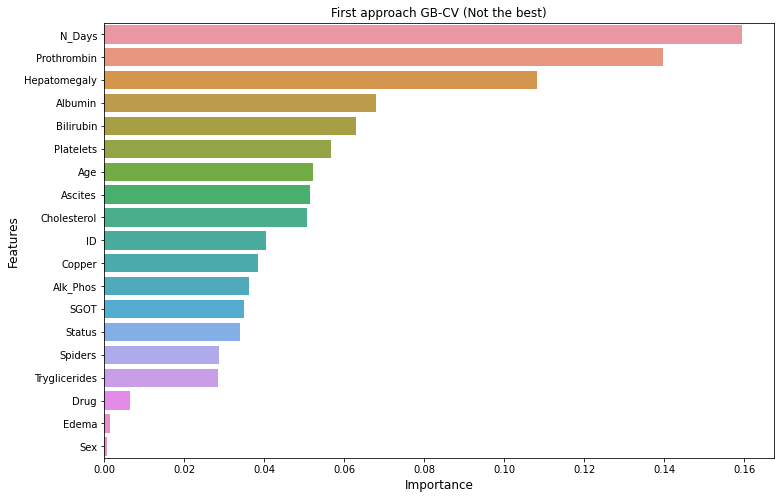

In [ ]:
plt.figure(figsize=(12, 8))
gb_indices = np.argsort(best_first_ap_model.feature_importances_)[::-1]
ax1 = sns.barplot(y=df.columns[gb_indices], x = best_first_ap_model.feature_importances_[gb_indices] , orient='h')
ax1.set_xlabel('Importance', fontsize=12)
ax1.set_ylabel('Features', fontsize=12)
ax1.set_title('First approach GB-CV (Not the best)')